In [35]:
import pandas as pd
import json

# Charger les données depuis les fichiers JSONL
meta_file = "meta.jsonl"
reviews_file = "reviews.jsonl"

# Lire les fichiers JSONL en DataFrames pandas
with open(reviews_file, 'r') as file:
    reviews_data = [json.loads(line) for line in file]

# Extraire les champs pertinents : "title" et "text"
selected_reviews = [{'title': review.get('title', ''), 'text': review.get('text', '')} for review in reviews_data]

# Créer un DataFrame à partir des champs sélectionnés
df_reviews = pd.DataFrame(selected_reviews)

# Sauvegarder le DataFrame dans un fichier JSON
output_file = "selected_reviews.json"
df_reviews.to_json(output_file, orient='records', lines=True, force_ascii=False)

# Sauvegarder le DataFrame dans un fichier CSV si nécessaire
output_csv_file = "selected_reviews.csv"
df_reviews.to_csv(output_csv_file, index=False, encoding='utf-8')

print("Les données sélectionnées ont été sauvegardées dans les fichiers suivants :")
print(f"- JSON : {output_file}")
print(f"- CSV : {output_csv_file}")


Les données sélectionnées ont été sauvegardées dans les fichiers suivants :
- JSON : selected_reviews.json
- CSV : selected_reviews.csv


2.Traitement linguistique

In [37]:
import spacy
import pandas as pd
import re
import json

# Charger le modèle spaCy
nlp = spacy.load("en_core_web_sm")

# Charger le fichier JSON contenant les données (généré précédemment)
input_file = "selected_reviews.json"
with open(input_file, "r", encoding="utf-8") as file:
    reviews_data = [json.loads(line) for line in file]

# Fonction de traitement linguistique
def process_text(text):
    # Analyse linguistique avec spaCy
    doc = nlp(text)
    
    tokens = []
    for token in doc:
        lemma = token.lemma_.lower()  # Convertir en minuscule et extraire le lemme
        # Filtrer : pas de stop words, pas de ponctuation, pas de nombres, pas de liens, pas de mots courts
        if (
            not token.is_stop and 
            not token.is_punct and 
            not token.like_num and 
            not token.like_url and 
            len(lemma) > 2
        ):
            tokens.append(lemma)
    
    return tokens

# Appliquer le traitement linguistique sur les avis
processed_reviews = []
for review in reviews_data:
    title_tokens = process_text(review.get("title", ""))
    text_tokens = process_text(review.get("text", ""))
    processed_reviews.append({
        "title": title_tokens,
        "text": text_tokens
    })

# Sauvegarder les données nettoyées dans un fichier JSON
output_file = "cleaned_reviews.json"
with open(output_file, "w", encoding="utf-8") as file:
    json.dump(processed_reviews, file, indent=4, ensure_ascii=False)

print(f"Les données nettoyées ont été sauvegardées dans : {output_file}")


Les données nettoyées ont été sauvegardées dans : cleaned_reviews.json


3.Sauvegarde des données préparées

In [38]:
import spacy
import json

# Charger le modèle spaCy
nlp = spacy.load("en_core_web_sm")

# Charger les données nettoyées
input_file = "cleaned_reviews.json"
with open(input_file, "r", encoding="utf-8") as file:
    reviews_data = json.load(file)

# Générer des listes de tokens (title + text combinés)
tokens_list = []
for review in reviews_data:
    combined_tokens = review["title"] + review["text"]  # Combiner title et text
    tokens_list.append(combined_tokens)

# Sauvegarder les listes résultantes dans un fichier JSON
output_file = "prepared_reviews_tokens.json"
with open(output_file, "w", encoding="utf-8") as file:
    json.dump(tokens_list, file, indent=4, ensure_ascii=False)

print(f"Les données préparées ont été sauvegardées dans : {output_file}")


Les données préparées ont été sauvegardées dans : prepared_reviews_tokens.json


Étape 2 : Clustering non supervisé des documents pour identifier des topics et mots-clés

In [49]:
import json
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer
import numpy as np
from scipy.sparse import save_npz

# Étape 1 : Charger le fichier JSON contenant des tokens pré-traités
input_file = "prepared_reviews_tokens.json"

try:
    with open(input_file, "r", encoding="utf-8") as file:
        documents = json.load(file)
except FileNotFoundError:
    print(f"Erreur : Le fichier {input_file} n'a pas été trouvé.")
    exit(1)

# Combine tokens en une chaîne de caractères pour chaque document
processed_docs = [" ".join(tokens) for tokens in documents]

# Option 1 : Génération des embeddings avec SentenceTransformers
try:
    print("Génération des embeddings avec SentenceTransformers...")
    model = SentenceTransformer('all-MiniLM-L6-v2')
    embeddings = model.encode(processed_docs)

    # Sauvegarder les embeddings dans un fichier JSON
    embeddings_file = "document_embeddings.json"
    with open(embeddings_file, "w", encoding="utf-8") as file:
        json.dump(embeddings.tolist(), file, indent=4)

    print(f"Embeddings générés et sauvegardés dans : {embeddings_file}")
except Exception as e:
    print(f"Erreur avec SentenceTransformers : {e}")

# Option 2 : Génération des embeddings avec TF-IDF Vectorizer
try:
    print("Génération des embeddings avec TF-IDF Vectorizer...")
    tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # Limiter le nombre de caractéristiques
    tfidf_matrix = tfidf_vectorizer.fit_transform(processed_docs)

    # Sauvegarder la matrice TF-IDF dans un fichier compressé pour usage futur
    tfidf_file = "tfidf_matrix.npz"
    save_npz(tfidf_file, tfidf_matrix)

    print(f"Matrice TF-IDF générée et sauvegardée dans : {tfidf_file}")
except Exception as e:
    print(f"Erreur avec TF-IDF Vectorizer : {e}")


Génération des embeddings avec SentenceTransformers...
Erreur avec SentenceTransformers : Numpy is not available
Génération des embeddings avec TF-IDF Vectorizer...
Matrice TF-IDF générée et sauvegardée dans : tfidf_matrix.npz


2.Clustering

In [3]:
import numpy as np
from scipy.sparse import load_npz

# Charger la matrice sparse TF-IDF
file_path = 'tfidf_matrix.npz'
tfidf_matrix = load_npz(file_path)

# Affichage de la forme de la matrice
print("Shape of the TF-IDF matrix:", tfidf_matrix.shape)


Shape of the TF-IDF matrix: (1000, 2871)


In [4]:
from sklearn.cluster import KMeans

# Définir le nombre de clusters
num_clusters = 3

# Appliquer KMeans
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(tfidf_matrix)

# Afficher les clusters assignés aux documents
print("Clusters KMeans:", kmeans.labels_)


Clusters KMeans: [2 2 2 2 1 2 2 0 1 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 1 2 2 0 2 2 2 2 2 2 2
 0 2 2 2 2 2 2 0 2 0 1 2 2 2 2 2 1 1 0 2 2 2 1 2 1 2 2 2 2 2 2 2 1 1 1 1 0
 2 2 2 2 1 2 1 2 2 2 2 2 2 2 2 2 2 2 2 1 1 2 2 1 1 2 2 2 2 2 2 1 2 1 1 2 1
 2 2 2 1 1 2 2 2 2 2 2 1 2 1 2 0 2 2 2 2 2 2 2 2 2 2 1 1 2 1 1 1 2 2 2 1 2
 2 2 1 2 1 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 1 1
 2 1 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 0 2 2 2 2 2 2 2 2 1 2 2 2 2 0 1
 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 1 1 2 2 2 2 2 1 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 1
 2 1 1 0 0 0 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 2 1 2 1 1 0 2 2 2 1 2
 1 2 2 2 2 2 1 2 2 2 2 1 1 1 2 2 2 2 2 2 2 2 2 1 1 1 2 2 2 0 0 1 0 2 2 2 2
 2 1 1 1 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 1 2 2 1 2 2 1 2 2 1 2 1 2 2 2 2 0 2
 2 2 2 1 1 2 1 2 1 2 2 2 2 2 2 1 2 1 1 2 2 2 2 2 2 0 0 2 1 2 2 0 2 1 2 2 2
 2 0 2 2 2 2 1 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 0 2 2 0 2 2 2 2 1 1 1
 1 1 2 2

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/Users/zekanedotcom/Downloads/Topic_Modelisation_Avis_Produits/.venv/lib/python3.12/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Matplotlib is building the font cache; this may take a moment.


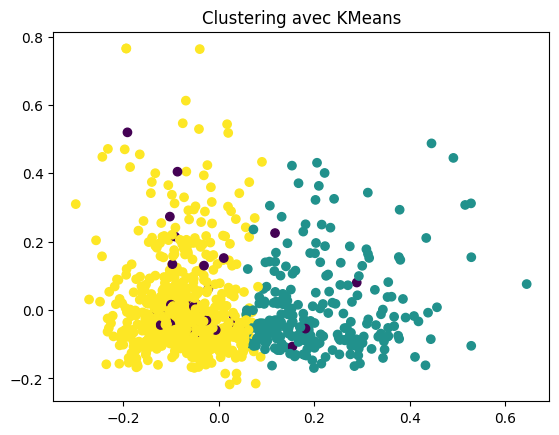

In [7]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Réduction de la dimensionnalité avec PCA à 2 dimensions
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(tfidf_matrix.toarray())

# Visualisation des clusters
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=kmeans.labels_, cmap='viridis')
plt.title("Clustering avec KMeans")
plt.show()


3.Analyse des clusters

1. Association des documents aux clusters 

In [8]:
from collections import defaultdict

# Créer un dictionnaire pour regrouper les documents par cluster
clustered_documents = defaultdict(list)

# Associer chaque document à un cluster
for idx, label in enumerate(kmeans.labels_):
    clustered_documents[label].append(idx)

# Afficher les clusters et les documents associés
for cluster, documents in clustered_documents.items():
    print(f"Cluster {cluster}: {documents}")


Cluster 2: [0, 1, 2, 3, 5, 6, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 30, 31, 32, 33, 34, 35, 36, 38, 39, 40, 41, 42, 43, 45, 48, 49, 50, 51, 52, 56, 57, 58, 60, 62, 63, 64, 65, 66, 67, 68, 74, 75, 76, 77, 79, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 95, 96, 99, 100, 101, 102, 103, 104, 106, 109, 111, 112, 113, 116, 117, 118, 119, 120, 121, 123, 125, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 139, 143, 144, 145, 147, 148, 149, 151, 153, 154, 155, 156, 157, 158, 159, 160, 161, 163, 164, 165, 166, 167, 168, 169, 170, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 185, 187, 188, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 203, 204, 205, 207, 208, 209, 210, 211, 212, 213, 214, 216, 217, 218, 219, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 269, 270, 271, 272, 273,

2. Fréquences des mots 

In [12]:
from scipy.sparse import load_npz
import numpy as np

# Charger la matrice sparse TF-IDF
file_path = 'tfidf_matrix.npz'
tfidf_matrix = load_npz(file_path)

# Charger les indices (si nécessaire pour obtenir les mots)
# indices = np.load('path/to/indices.npy')

# Supposons que vous avez une liste de termes, sinon vous devrez la recréer
feature_names = np.array(["term_1", "term_2", "term_3", ...])  # À remplacer par votre propre vocabulaire ou chargement.


In [14]:
from collections import defaultdict

# Calculer les fréquences des mots par cluster
word_frequencies = defaultdict(lambda: defaultdict(int))

for cluster, documents in clustered_documents.items():
    for doc_idx in documents:
        # Récupérer les indices des termes pour chaque document
        row = tfidf_matrix[doc_idx].toarray().flatten()
        
        for idx, freq in enumerate(row):
            if freq > 4:
                word_frequencies[cluster][feature_names[idx]] += freq

# Afficher les fréquences des mots pour chaque cluster
for cluster, freqs in word_frequencies.items():
    print(f"Cluster {cluster} - Frequencies of words:")
    sorted_freqs = sorted(freqs.items(), key=lambda x: x[1], reverse=True)
    for word, freq in sorted_freqs[:10]:  # Top 10 mots
        print(f"{word}: {freq}")


In [16]:
# Afficher les clusters et les documents associés
for cluster, documents in clustered_documents.items():
    print(f"Cluster {cluster}:")
    for doc_idx in documents:
        print(f"Document {doc_idx}: {documents[doc_idx]}")  # Remplacez par le texte du document si disponible.


Cluster 2:
Document 0: 0
Document 1: 1
Document 2: 2
Document 3: 3
Document 5: 6
Document 6: 9
Document 9: 12
Document 10: 13
Document 11: 14
Document 12: 15
Document 13: 16
Document 14: 18
Document 15: 19
Document 16: 20
Document 18: 22
Document 19: 23
Document 20: 24
Document 21: 25
Document 22: 27
Document 23: 28
Document 24: 30
Document 25: 31
Document 27: 33
Document 28: 34
Document 30: 36
Document 31: 38
Document 32: 39
Document 33: 40
Document 34: 41
Document 35: 42
Document 36: 43
Document 38: 48
Document 39: 49
Document 40: 50
Document 41: 51
Document 42: 52
Document 43: 56
Document 45: 58
Document 48: 63
Document 49: 64
Document 50: 65
Document 51: 66
Document 52: 67
Document 56: 76
Document 57: 77
Document 58: 79
Document 60: 82
Document 62: 84
Document 63: 85
Document 64: 86
Document 65: 87
Document 66: 88
Document 67: 89
Document 68: 90
Document 74: 100
Document 75: 101
Document 76: 102
Document 77: 103
Document 79: 106
Document 81: 111
Document 82: 112
Document 83: 113
Do

IndexError: list index out of range

Étape 3 : Analyse des sentiments des avis clients

1. Chargement et préparation des données

In [19]:
import json

# Étape 1 : Charger le fichier JSONL contenant les avis clients
input_file = "reviews.jsonl"  # Remplacez par le nom du fichier JSONL

try:
    with open(input_file, "r", encoding="utf-8") as file:
        # Charger les objets JSON ligne par ligne
        reviews_data = [json.loads(line) for line in file]
except FileNotFoundError:
    print(f"Erreur : Le fichier {input_file} n'a pas été trouvé.")
    exit(1)
except json.JSONDecodeError:
    print("Erreur : Le fichier JSONL contient des lignes malformées.")
    exit(1)

# Vérifiez si le fichier contient au moins 200 avis
if len(reviews_data) < 200:
    print(f"Erreur : Le fichier contient seulement {len(reviews_data)} avis.")
    exit(1)

# Étape 2 : Extraire les 200 premières données (avis)
reviews_subset = reviews_data[:200]  # Prendre les 200 premiers avis

# Étape 3 : Extraire les ratings des avis pour une évaluation future
try:
    ratings = [review['rating'] for review in reviews_subset]  # Adaptez cette ligne selon la structure exacte
except KeyError:
    print("Erreur : La clé 'rating' n'existe pas dans le fichier JSONL. Vérifiez sa structure.")
    exit(1)

# Affichage des 200 premières données et des ratings
print(f"Exemple d'avis (200 premiers) : {reviews_subset[:3]}")  # Affiche les 3 premiers avis
print(f"Exemple de ratings : {ratings[:3]}")  # Affiche les 3 premiers ratings


Exemple d'avis (200 premiers) : [{'rating': 4.0, 'title': 'No white background! It’s clear!', 'text': 'I bought this bc I thought it had the nice white background. Turns out it’s clear & since my phone is blue it doesn’t look anything like this.  If I had known that I would have purchased something else. It works ok.', 'images': [{'small_image_url': 'https://images-na.ssl-images-amazon.com/images/I/B1PrCo7ZjXS._SL256_.jpg', 'medium_image_url': 'https://images-na.ssl-images-amazon.com/images/I/B1PrCo7ZjXS._SL800_.jpg', 'large_image_url': 'https://images-na.ssl-images-amazon.com/images/I/B1PrCo7ZjXS._SL1600_.jpg', 'attachment_type': 'IMAGE'}], 'asin': 'B08L6L3X1S', 'parent_asin': 'B08L6L3X1S', 'user_id': 'AFKZENTNBQ7A7V7UXW5JJI6UGRYQ', 'timestamp': 1612044451196, 'helpful_vote': 0, 'verified_purchase': True}, {'rating': 5.0, 'title': 'Awesome!  Great price!  Works well!', 'text': 'Perfect. How pissed am I that I recently paid $20 for 1 Fitbit cable and promptly lost the damned thing?  Ex

2. Chargement du modèle pré-entraîné

In [26]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Étape 1 : Charger le tokenizer et le modèle pré-entraîné
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"

try:
    print(f"Chargement du modèle '{model_name}'...")
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name)
    print("Modèle et tokenizer chargés avec succès.")
except Exception as e:
    print(f"Erreur lors du chargement du modèle ou du tokenizer : {e}")
    exit(1)


Chargement du modèle 'nlptown/bert-base-multilingual-uncased-sentiment'...
Modèle et tokenizer chargés avec succès.


In [25]:
from scipy.stats import pearsonr
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import json

# Charger les 200 premières données depuis le fichier JSONL
input_file = "reviews.jsonl"

reviews_subset = []
ratings = []

try:
    with open(input_file, "r", encoding="utf-8") as file:
        for idx, line in enumerate(file):
            if idx >= 200:  # Prendre uniquement les 200 premières
                break
            review = json.loads(line)
            reviews_subset.append(review["text"])  # Assurez-vous que "text" est la clé des avis
            ratings.append(review["rating"])  # Assurez-vous que "rating" est la clé des ratings
except FileNotFoundError:
    print(f"Erreur : Le fichier {input_file} n'a pas été trouvé.")
    exit(1)

# Charger le tokenizer et le modèle de sentiments
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Fonction pour prédire les scores de sentiments
def get_sentiment_score(review_text):
    inputs = tokenizer(review_text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    outputs = model(**inputs)
    scores = torch.softmax(outputs.logits, dim=1)
    sentiment_score = torch.argmax(scores, dim=1).item() + 1  # Ajouter 1 car les scores commencent à 0
    return sentiment_score

# Prédire les sentiments pour les 200 avis
predicted_sentiments = [get_sentiment_score(review) for review in reviews_subset]

# Calculer la corrélation entre les prédictions de sentiments et les ratings
correlation, p_value = pearsonr(predicted_sentiments, ratings)

# Afficher les résultats
print(f"Corrélation entre les prédictions de sentiments et les ratings : {correlation:.2f}")
print(f"Valeur p associée : {p_value:.4f}")


Corrélation entre les prédictions de sentiments et les ratings : 0.83
Valeur p associée : 0.0000


3. Prétraitement des données

In [31]:
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from scipy.stats import pearsonr
import json

# Charger les données JSONL (200 premiers avis)
input_file = "reviews.jsonl"

class ReviewDataset(Dataset):
    def __init__(self, reviews, ratings):
        self.reviews = reviews
        self.ratings = ratings

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, idx):
        return {"review": self.reviews[idx], "rating": self.ratings[idx]}

reviews_subset = []
ratings = []

try:
    with open(input_file, "r", encoding="utf-8") as file:
        for idx, line in enumerate(file):
            if idx >= 200:  # Limiter aux 200 premiers avis
                break
            review = json.loads(line)
            reviews_subset.append(review["text"])  # Assurez-vous que "text" est la clé des avis
            ratings.append(review["rating"])  # Assurez-vous que "rating" est la clé des ratings
except FileNotFoundError:
    print(f"Erreur : Le fichier {input_file} n'a pas été trouvé.")
    exit(1)

# Initialisation du DataLoader
batch_size = 16  # Ajustez en fonction des ressources disponibles
dataset = ReviewDataset(reviews_subset, ratings)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Charger le modèle pré-entraîné et le tokenizer
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Fonction pour prédire les sentiments d'un lot (batch)
def predict_batch(batch):
    texts = batch["review"]
    inputs = tokenizer(list(texts), return_tensors="pt", truncation=True, padding=True, max_length=512)
    outputs = model(**inputs)
    scores = torch.softmax(outputs.logits, dim=1)
    sentiments = torch.argmax(scores, dim=1) + 1  # Ajouter 1 car les scores vont de 0 à 4
    return sentiments.tolist()

# Prédictions par lots
all_predicted_sentiments = []

for batch in dataloader:
    sentiments = predict_batch(batch)
    all_predicted_sentiments.extend(sentiments)

# Calcul de la corrélation entre les prédictions et les ratings
correlation, p_value = pearsonr(all_predicted_sentiments, ratings)

# Afficher les résultats
print(f"Corrélation entre les prédictions de sentiments et les ratings : {correlation:.2f}")
print(f"Valeur p associée : {p_value:.4f}")


Corrélation entre les prédictions de sentiments et les ratings : 0.83
Valeur p associée : 0.0000


4. Analyse des sentiments

In [33]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from torch.utils.data import DataLoader, Dataset

# Charger les données JSONL (200 premiers avis)
input_file = "reviews.jsonl"

class ReviewDataset(Dataset):
    def __init__(self, reviews):
        self.reviews = reviews

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, idx):
        return self.reviews[idx]

# Charger et extraire les avis
reviews_subset = []

try:
    with open(input_file, "r", encoding="utf-8") as file:
        for idx, line in enumerate(file):
            if idx >= 200:  # Limiter aux 200 premiers avis
                break
            review = json.loads(line)
            reviews_subset.append(review["text"])  # Assurez-vous que "text" est la clé des avis
except FileNotFoundError:
    print(f"Erreur : Le fichier {input_file} n'a pas été trouvé.")
    exit(1)

# Initialisation du DataLoader
batch_size = 16
dataset = ReviewDataset(reviews_subset)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Charger le modèle et le tokenizer
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Fonction pour analyser les sentiments
def analyze_sentiments(batch_texts):
    inputs = tokenizer(list(batch_texts), return_tensors="pt", truncation=True, padding=True, max_length=512)
    outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.softmax(logits, dim=1)
    sentiments = torch.argmax(probabilities, dim=1) + 1  # Les labels vont de 1 à 5
    return sentiments.tolist()

# Passer les données dans le modèle
all_sentiments = []
for batch in dataloader:
    batch_sentiments = analyze_sentiments(batch)
    all_sentiments.extend(batch_sentiments)

# Affichage des résultats
print(f"Prédictions de sentiments pour les 200 avis : {all_sentiments[:10]}")  # Affiche les 10 premiers


Prédictions de sentiments pour les 200 avis : [3, 5, 4, 2, 5, 5, 5, 5, 5, 4]


5. Évaluation des performances

Remarques : pour la partie 4 du projet, je fais comme vous le recommander 
c'est à dire travailler sur les 200 premiers ensemble de données.

In [34]:
from scipy.stats import pearsonr

# Étape 1 : Associer les sentiments prédits à des scores numériques
# (Déjà fait car les prédictions `all_sentiments` sont entre 1 et 5)

# Assurez-vous que les ratings (notes réelles) ont été extraites lors des étapes précédentes
# Exemple : ratings = [4, 3, 5, ...] correspondant aux 200 premiers avis

# Étape 2 : Calculer la corrélation de Pearson entre les notes réelles et les prédictions
try:
    correlation, p_value = pearsonr(all_sentiments, ratings)

    # Afficher les résultats
    print(f"Corrélation de Pearson entre les notes réelles et les sentiments prédits : {correlation:.2f}")
    print(f"P-value associée : {p_value:.4f}")
except Exception as e:
    print(f"Erreur lors du calcul de la corrélation : {e}")


Corrélation de Pearson entre les notes réelles et les sentiments prédits : 0.83
P-value associée : 0.0000


BONUS : Essayer d’autres modèles et visualisations

Visualisation : Distributions des notes réelles et prédites

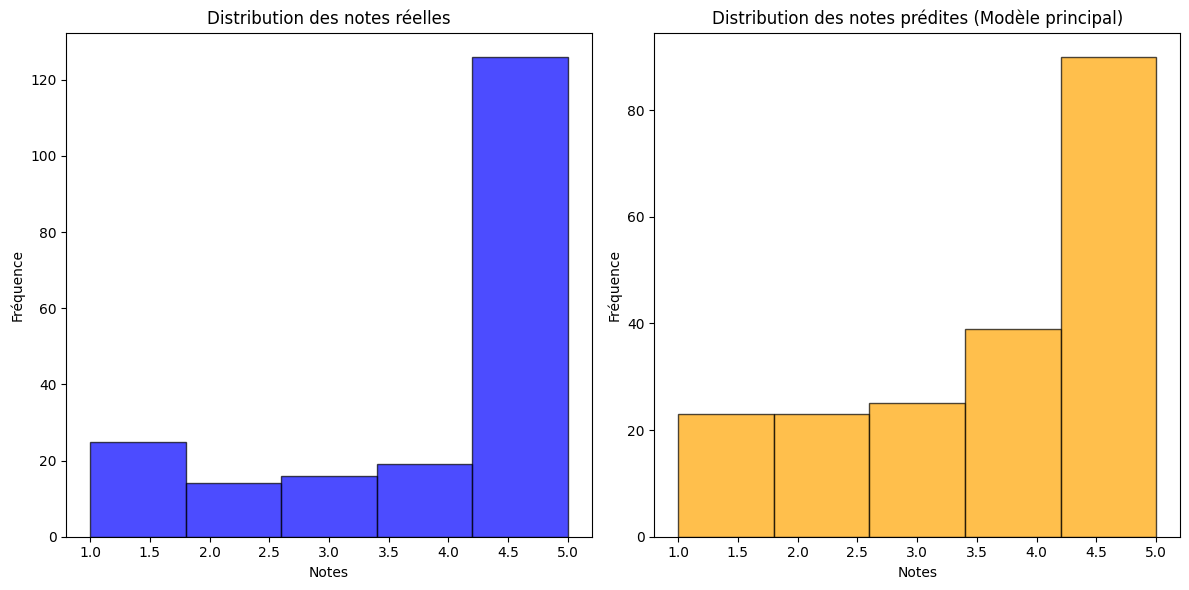

A la prochaine pour d'autres études de modèle.


In [39]:
import matplotlib.pyplot as plt

# Comparaison des distributions
plt.figure(figsize=(12, 6))

# Histogramme des notes réelles
plt.subplot(1, 2, 1)
plt.hist(ratings, bins=5, alpha=0.7, color='blue', edgecolor='black')
plt.title("Distribution des notes réelles")
plt.xlabel("Notes")
plt.ylabel("Fréquence")

# Histogramme des notes prédites
plt.subplot(1, 2, 2)
plt.hist(all_sentiments, bins=5, alpha=0.7, color='orange', edgecolor='black')
plt.title("Distribution des notes prédites (Modèle principal)")
plt.xlabel("Notes")
plt.ylabel("Fréquence")

plt.tight_layout()
plt.show()


# Vérifiez si alt_sentiments est défini
if 'alt_sentiments' in locals() and alt_sentiments:
    # Comparaison entre deux modèles
    plt.figure(figsize=(10, 5))
    plt.hist(all_sentiments, bins=5, alpha=0.5, label="Modèle principal", color='orange', edgecolor='black')
    plt.hist(alt_sentiments, bins=5, alpha=0.5, label="Modèle alternatif", color='green', edgecolor='black')
    plt.title("Comparaison des distributions des modèles")
    plt.xlabel("Notes")
    plt.ylabel("Fréquence")
    plt.legend()
    plt.show()
else:
    print("A la prochaine pour d'autres études de modèle.")


cardiffnlp/twitter-roberta-base-sentiment : 

un modèle pré-entraîné basé sur RoBERTa développé par Cardiff NLP.

In [40]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# Charger un autre modèle de Hugging Face
alt_model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(alt_model_name)
model = AutoModelForSequenceClassification.from_pretrained(alt_model_name)

# Prévoir les sentiments en utilisant ce modèle
def get_sentiment_alt(review_text):
    inputs = tokenizer(review_text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    outputs = model(**inputs)
    scores = torch.softmax(outputs.logits, dim=1).detach().cpu().numpy()
    sentiment_score = np.argmax(scores, axis=1) + 1  # Ajuster selon les classes du modèle
    return sentiment_score[0]

# Reprédire avec le nouveau modèle
alt_sentiments = [get_sentiment_alt(review) for review in reviews_subset]


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

RuntimeError: Numpy is not available